# Data Science Capstone Project

## Summary:
* [Business Problem](#business_problem)
* [Data understanding](#data_understanding)
* [Exploratory Data Analysis](#eda)
* [Modeling](#modeling)
* [Evaluation](#evaluation)
* [Conclusion](#conclusion)

## Business problem <a name="business_problem"></a>

Todos os anos, várias pessoas morrem por acidentes de carros, seja por desatenção, algo na pista que causou o acidente, a iluminação, fatores externos, etc. Muitos sofrem acidentes e não recebem o cuidado necessário de imediato, causando a morte do individuo no caminho ao hospital, no local do acidente ou posteriormente.
O foco desse projeto será tentar prever a gravidade de um acidente, baseado em dados anteriores de acidentes, para ajudar autoridades, hospitais, serviços de saúde pública e, claro, o próprio motorista.
Para isso, vamos usar algoritmos de aprendizagem supervisionada de Machine Learning para prever a gravidade de acidentes futuros e poder alertar os orgãos responsáveis para trabalhar no acidente e tentar reduzir o nível de fatalidade de acidentes.

## Data understanding <a name="data_understanding"></a>

Os dados que iremos usar vem do SDOT Traffic Management Division, Traffic Records Group, em formato CSV. Os dados são de Seattle, e datam de 2004 até os dias atuais, são dados atualizados semanalmente, então, posteriormente, podemos fazer com que nosso modelo absorva mais dados futuros, tanto para melhorar a acuracia, quanto para procurar novas tendencias nos dados e entregar um melhor resultado.
Dentro do arquivo CSV temos colunas que representam tipos de dados diversos, tais como a data do acidente, condições da pista, numero de acidentados, quantidade de carros involvidos, pedestres, ciclistas, etc. Também temos muitas colunas que servem apenas para identificação de cada acidente por orgãos que lidam com esse tipo de trabalho. Além disso, temos muitos valores vazios e desconhecidos que precisamos lidar com algumas técnicas.
Podemos ter mais informações de cada coluna no arquivo <b>METADATA.pdf</b> para saber pra que cada variável serve.
A coluna que precisamos prever é a "SEVERITYCODE" que tem o valor da gravidade do acidente, quanto maior, maior a gravidade. Através de algumas analises, podemos ver que atualmente iremos lidar com apenas dois valores: 1 ou 2 (dano apenas a propriedades e pessoas machucadas no acidente, respectivamente).
Um forte candidato para decisão binária (onde só há duas possibilidades) é usar o algoritmo de Regressão Logística, porém iremos tentar outros algoritmos para ver qual tem uma melhor avaliação.

### Importing libraries

In [1]:
# Pandas to handle dataset
import pandas as pd 

# Numpy to handle and operate through arrays
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Removing warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# Read the dataset
df_collisions = pd.read_csv("https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv")

 ## Exploratory data analysis <a name="eda"></a>

In this dataset, we have a lot of columns that are only used for identification by the authorities, so we need to remove these useless columns to make our DataFrame smaller and use only the columns that have impact in our decisions.
For more info about these columns, check the <b>Metadata.pdf</b>

In [3]:
useless_columns = ['OBJECTID', 'X', 'Y', 'REPORTNO', 'STATUS', 'INCDTTM', 'INCKEY', 'COLDETKEY', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'INCDATE', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'SDOTCOLNUM', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY']

df_collisions.drop(columns=useless_columns, inplace=True)

print(df_collisions.columns)

Index(['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER',
       'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING', 'HITPARKEDCAR'],
      dtype='object')


Let's check the first five rows in the dataframe and check the type of each column

In [4]:
df_collisions.head()

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR
0,2,Intersection,Angles,2,0,0,2,NaN,N,Overcast,Wet,Daylight,NaN,NaN,N
1,1,Block,Sideswipe,2,0,0,2,NaN,0,Raining,Wet,Dark - Street Lights On,NaN,NaN,N
2,1,Block,Parked Car,4,0,0,3,NaN,0,Overcast,Dry,Daylight,NaN,NaN,N
3,1,Block,Other,3,0,0,3,NaN,N,Clear,Dry,Daylight,NaN,NaN,N
4,2,Intersection,Angles,2,0,0,2,NaN,0,Raining,Wet,Daylight,NaN,NaN,N


In [5]:
df_collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   SEVERITYCODE    194673 non-null  int64 
 1   ADDRTYPE        192747 non-null  object
 2   COLLISIONTYPE   189769 non-null  object
 3   PERSONCOUNT     194673 non-null  int64 
 4   PEDCOUNT        194673 non-null  int64 
 5   PEDCYLCOUNT     194673 non-null  int64 
 6   VEHCOUNT        194673 non-null  int64 
 7   INATTENTIONIND  29805 non-null   object
 8   UNDERINFL       189789 non-null  object
 9   WEATHER         189592 non-null  object
 10  ROADCOND        189661 non-null  object
 11  LIGHTCOND       189503 non-null  object
 12  PEDROWNOTGRNT   4667 non-null    object
 13  SPEEDING        9333 non-null    object
 14  HITPARKEDCAR    194673 non-null  object
dtypes: int64(5), object(10)
memory usage: 22.3+ MB


### Missing values

Now, let's check our dataframe for missing values and how we'll handle then.

In [6]:
df_collisions.isnull().sum()

SEVERITYCODE           0
ADDRTYPE            1926
COLLISIONTYPE       4904
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INATTENTIONIND    164868
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
PEDROWNOTGRNT     190006
SPEEDING          185340
HITPARKEDCAR           0
dtype: int64

We can use 3 methods to handle missing data:
 - replacing by column average;
 - replacing by column most recurring value; or
 - deleting entire row/column with missing data

We can drop columns with 50% or more missing values

In [7]:
print('Inital total columns: ' + str(np.asarray(df_collisions.columns).size))

df_collisions.dropna(axis=1, thresh=97336, inplace=True)

print('Total columns after dropping: ' + str(np.asarray(df_collisions.columns).size))

Inital total columns: 15
Total columns after dropping: 12


In [8]:
# Dataset is imbalanced, so lets grab samples and balance that using undersampling technique
df_collisions.SEVERITYCODE.value_counts()

df_shuffled = df_collisions.sample(frac=1)

df_severitycode_2 = df_shuffled.loc[df_shuffled['SEVERITYCODE'] == 2]
df_severitycode_1 = df_shuffled.loc[df_shuffled['SEVERITYCODE'] == 1].sample(n=58188)

df_collisions = pd.concat([df_severitycode_1, df_severitycode_2])
df_collisions.SEVERITYCODE.value_counts()

2    58188
1    58188
Name: SEVERITYCODE, dtype: int64

<p>Since the remaing columns with missing values are categorical, we can fill those missing values with the recurrent value</p>

In [9]:
cols_with_missing_values = ['ADDRTYPE', 'COLLISIONTYPE', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND']

df_collisions[cols_with_missing_values].head()

,ADDRTYPE,COLLISIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND
178292,Intersection,Left Turn,N,Clear,Dry,Daylight
3248,Intersection,Right Turn,N,Clear,Dry,Daylight
129482,Block,Parked Car,N,Clear,Dry,Daylight
57299,Block,Sideswipe,0,Raining,Wet,Daylight
25946,Intersection,Angles,0,Clear,Dry,Daylight


We can see that UNDERINFL column has numeric and string values, so we need to handle it individually. We can replace 0 with 'No' and 1 with 'Yes' values.

In [10]:
df_collisions['UNDERINFL'] = df_collisions['UNDERINFL'].map({'0': 'No', '1': 'Yes', 'N': 'No', 'Y': 'Yes'})

Now lets fill those missing values with the recurrent value

In [11]:
df_collisions['ADDRTYPE'].fillna(df_collisions['ADDRTYPE'].mode()[0], inplace=True)
df_collisions['COLLISIONTYPE'].fillna(df_collisions['COLLISIONTYPE'].mode()[0], inplace=True)
df_collisions['UNDERINFL'].fillna(df_collisions['UNDERINFL'].mode()[0], inplace=True)
df_collisions['WEATHER'].fillna(df_collisions['WEATHER'].mode()[0], inplace=True)
df_collisions['ROADCOND'].fillna(df_collisions['ROADCOND'].mode()[0], inplace=True)
df_collisions['LIGHTCOND'].fillna(df_collisions['LIGHTCOND'].mode()[0], inplace=True)

### Data Wrangling

Now, lets use <b>OneHotEncoding</b> and <b>get_dummies</b> to handle categorical values

In [12]:
df_collisions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116376 entries, 178292 to 115751
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   SEVERITYCODE   116376 non-null  int64 
 1   ADDRTYPE       116376 non-null  object
 2   COLLISIONTYPE  116376 non-null  object
 3   PERSONCOUNT    116376 non-null  int64 
 4   PEDCOUNT       116376 non-null  int64 
 5   PEDCYLCOUNT    116376 non-null  int64 
 6   VEHCOUNT       116376 non-null  int64 
 7   UNDERINFL      116376 non-null  object
 8   WEATHER        116376 non-null  object
 9   ROADCOND       116376 non-null  object
 10  LIGHTCOND      116376 non-null  object
 11  HITPARKEDCAR   116376 non-null  object
dtypes: int64(5), object(7)
memory usage: 11.5+ MB


####  One-hot Encoding

In [13]:
# ADDRTYPE
df_collisions.ADDRTYPE.value_counts()

Block           72351
Intersection    43656
Alley             369
Name: ADDRTYPE, dtype: int64

In [14]:
# COLLISIONTYPE
df_collisions.COLLISIONTYPE.value_counts()

Rear Ended    25760
Angles        22602
Parked Car    21986
Other         13587
Sideswipe      9244
Left Turn      8981
Pedestrian     6227
Cycles         5029
Right Turn     1601
Head On        1359
Name: COLLISIONTYPE, dtype: int64

In [15]:
# UNDERINFL
df_collisions.UNDERINFL.value_counts()

No     110375
Yes      6001
Name: UNDERINFL, dtype: int64

In [16]:
# COLLISIONTYPE
df_collisions.HITPARKEDCAR.value_counts()

N    113019
Y      3357
Name: HITPARKEDCAR, dtype: int64

<AxesSubplot:xlabel='HITPARKEDCAR', ylabel='SEVERITYCODE'>

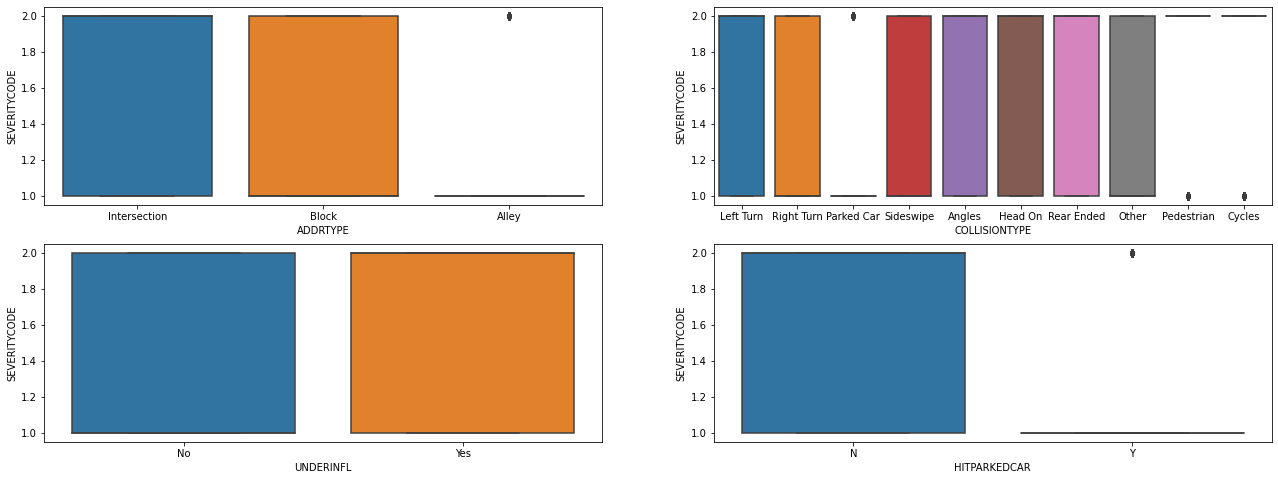

In [17]:
fig = plt.figure(figsize=(22, 8))

fig.add_subplot(2, 2, 1)
sns.boxplot(data=df_collisions, x='ADDRTYPE', y='SEVERITYCODE')

fig.add_subplot(2, 2, 2)
sns.boxplot(data=df_collisions, x='COLLISIONTYPE', y='SEVERITYCODE')

fig.add_subplot(2, 2, 3)
sns.boxplot(data=df_collisions, x='UNDERINFL', y='SEVERITYCODE')

fig.add_subplot(2, 2, 4)
sns.boxplot(data=df_collisions, x='HITPARKEDCAR', y='SEVERITYCODE')

<AxesSubplot:xlabel='HITPARKEDCAR', ylabel='SEVERITYCODE'>

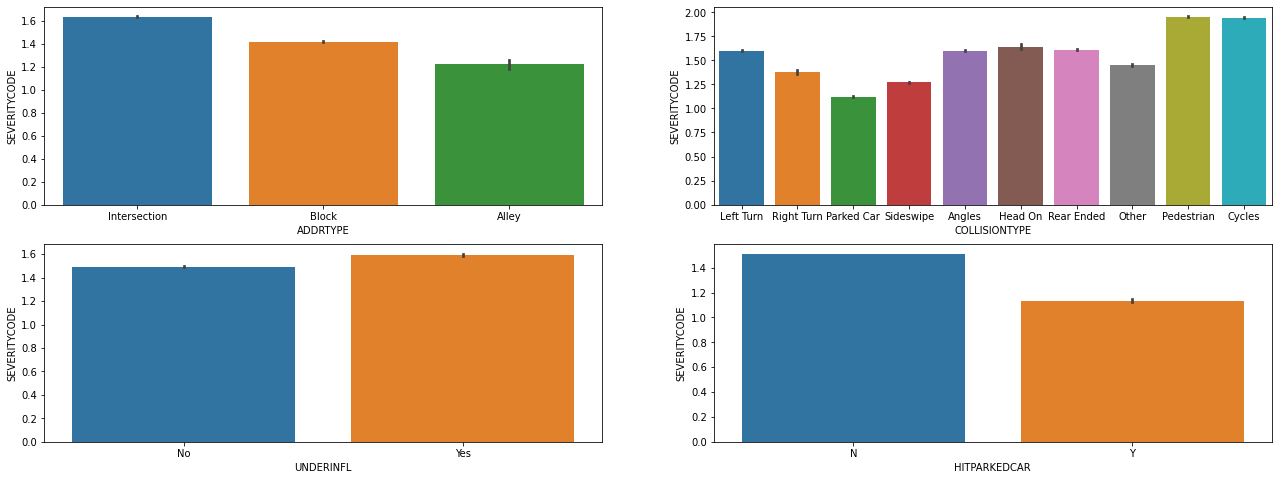

In [18]:
fig = plt.figure(figsize=(22, 8))

fig.add_subplot(2, 2, 1)
sns.barplot(data=df_collisions, x='ADDRTYPE', y='SEVERITYCODE')

fig.add_subplot(2, 2, 2)
sns.barplot(data=df_collisions, x='COLLISIONTYPE', y='SEVERITYCODE')

fig.add_subplot(2, 2, 3)
sns.barplot(data=df_collisions, x='UNDERINFL', y='SEVERITYCODE')

fig.add_subplot(2, 2, 4)
sns.barplot(data=df_collisions, x='HITPARKEDCAR', y='SEVERITYCODE')

<AxesSubplot:xlabel='HITPARKEDCAR', ylabel='SEVERITYCODE'>

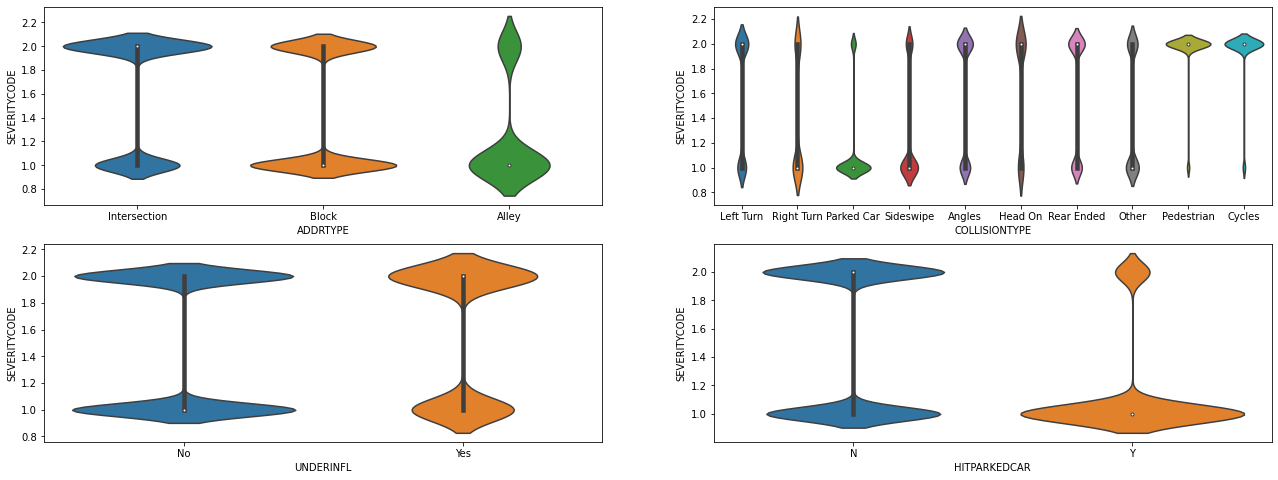

In [19]:
fig = plt.figure(figsize=(22, 8))

fig.add_subplot(2, 2, 1)
sns.violinplot(data=df_collisions, x='ADDRTYPE', y='SEVERITYCODE')

fig.add_subplot(2, 2, 2)
sns.violinplot(data=df_collisions, x='COLLISIONTYPE', y='SEVERITYCODE')

fig.add_subplot(2, 2, 3)
sns.violinplot(data=df_collisions, x='UNDERINFL', y='SEVERITYCODE')

fig.add_subplot(2, 2, 4)
sns.violinplot(data=df_collisions, x='HITPARKEDCAR', y='SEVERITYCODE')

Since there's no number sequencing in these columns's values, we can use get_dummies in the columns above

In [20]:
object_columns = ['ADDRTYPE', 'COLLISIONTYPE', 'UNDERINFL', 'HITPARKEDCAR']
df_collisions = pd.get_dummies(df_collisions, prefix=['addrtype', 'collisiontype', 'underinfl', 'hitparkedcar'], prefix_sep='_', columns=object_columns, drop_first=True)

#### Label encoding

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
# WEATHER
df_collisions.WEATHER.value_counts()

Clear                       70823
Raining                     20544
Overcast                    16808
Unknown                      6821
Snowing                       480
Other                         440
Fog/Smog/Smoke                345
Sleet/Hail/Freezing Rain       61
Blowing Sand/Dirt              36
Severe Crosswind               14
Partly Cloudy                   4
Name: WEATHER, dtype: int64

In [23]:
# ROADCOND
df_collisions.ROADCOND.value_counts()

Dry               78916
Wet               29264
Unknown            6782
Ice                 658
Snow/Slush          538
Other                73
Standing Water       61
Sand/Mud/Dirt        44
Oil                  40
Name: ROADCOND, dtype: int64

In [24]:
# COLLISIONTYPE
df_collisions.LIGHTCOND.value_counts()

Daylight                    74617
Dark - Street Lights On     28868
Unknown                      6102
Dusk                         3574
Dawn                         1536
Dark - No Street Lights       842
Dark - Street Lights Off      699
Other                         130
Dark - Unknown Lighting         8
Name: LIGHTCOND, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Daylight'),
  Text(1, 0, 'Dark - Street Lights On'),
  Text(2, 0, 'Dusk'),
  Text(3, 0, 'Dawn'),
  Text(4, 0, 'Unknown'),
  Text(5, 0, 'Dark - No Street Lights'),
  Text(6, 0, 'Dark - Street Lights Off'),
  Text(7, 0, 'Other'),
  Text(8, 0, 'Dark - Unknown Lighting')])

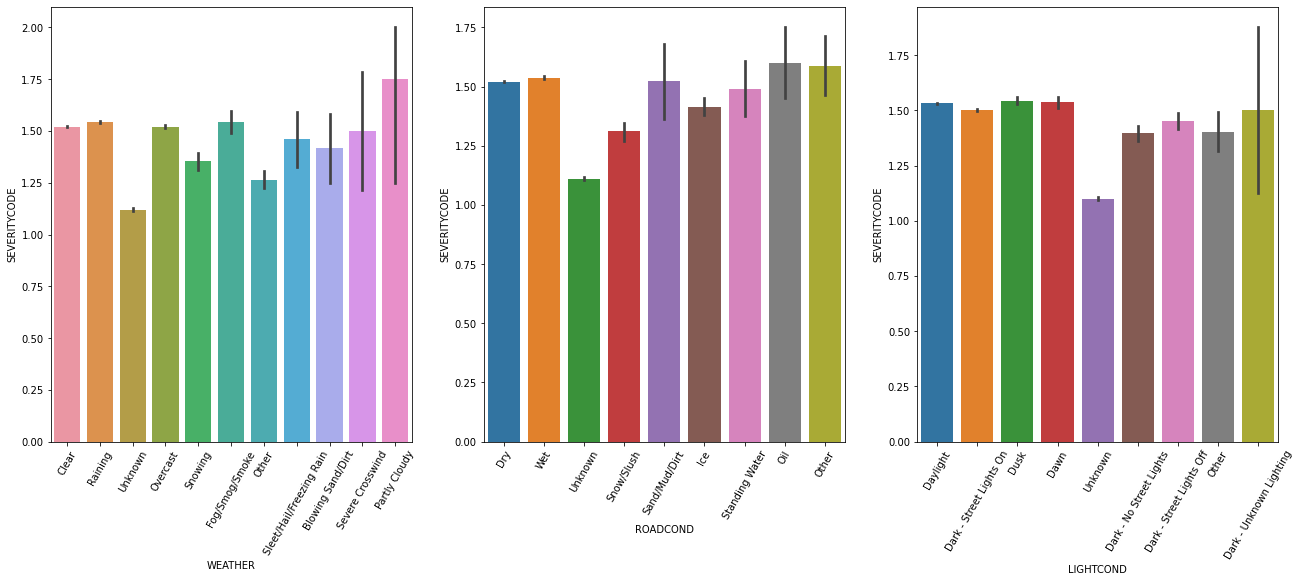

In [25]:
fig = plt.figure(figsize=(22, 8))

fig.add_subplot(1, 3, 1)
sns.barplot(data=df_collisions, x='WEATHER', y='SEVERITYCODE')
plt.xticks(rotation=60)

fig.add_subplot(1, 3, 2)
sns.barplot(data=df_collisions, x='ROADCOND', y='SEVERITYCODE')
plt.xticks(rotation=60)

fig.add_subplot(1, 3, 3)
sns.barplot(data=df_collisions, x='LIGHTCOND', y='SEVERITYCODE')
plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Daylight'),
  Text(1, 0, 'Dark - Street Lights On'),
  Text(2, 0, 'Dusk'),
  Text(3, 0, 'Dawn'),
  Text(4, 0, 'Unknown'),
  Text(5, 0, 'Dark - No Street Lights'),
  Text(6, 0, 'Dark - Street Lights Off'),
  Text(7, 0, 'Other'),
  Text(8, 0, 'Dark - Unknown Lighting')])

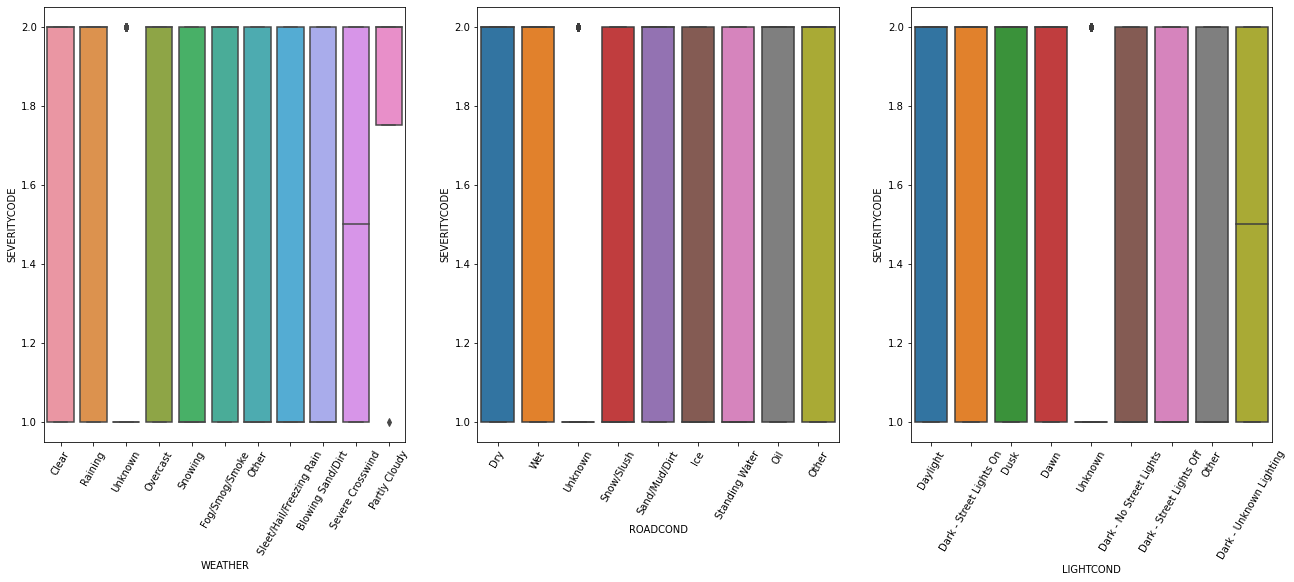

In [26]:
fig = plt.figure(figsize=(22, 8))

fig.add_subplot(1, 3, 1)
sns.boxplot(data=df_collisions, x='WEATHER', y='SEVERITYCODE')
plt.xticks(rotation=60)

fig.add_subplot(1, 3, 2)
sns.boxplot(data=df_collisions, x='ROADCOND', y='SEVERITYCODE')
plt.xticks(rotation=60)

fig.add_subplot(1, 3, 3)
sns.boxplot(data=df_collisions, x='LIGHTCOND', y='SEVERITYCODE')
plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Daylight'),
  Text(1, 0, 'Dark - Street Lights On'),
  Text(2, 0, 'Dusk'),
  Text(3, 0, 'Dawn'),
  Text(4, 0, 'Unknown'),
  Text(5, 0, 'Dark - No Street Lights'),
  Text(6, 0, 'Dark - Street Lights Off'),
  Text(7, 0, 'Other'),
  Text(8, 0, 'Dark - Unknown Lighting')])

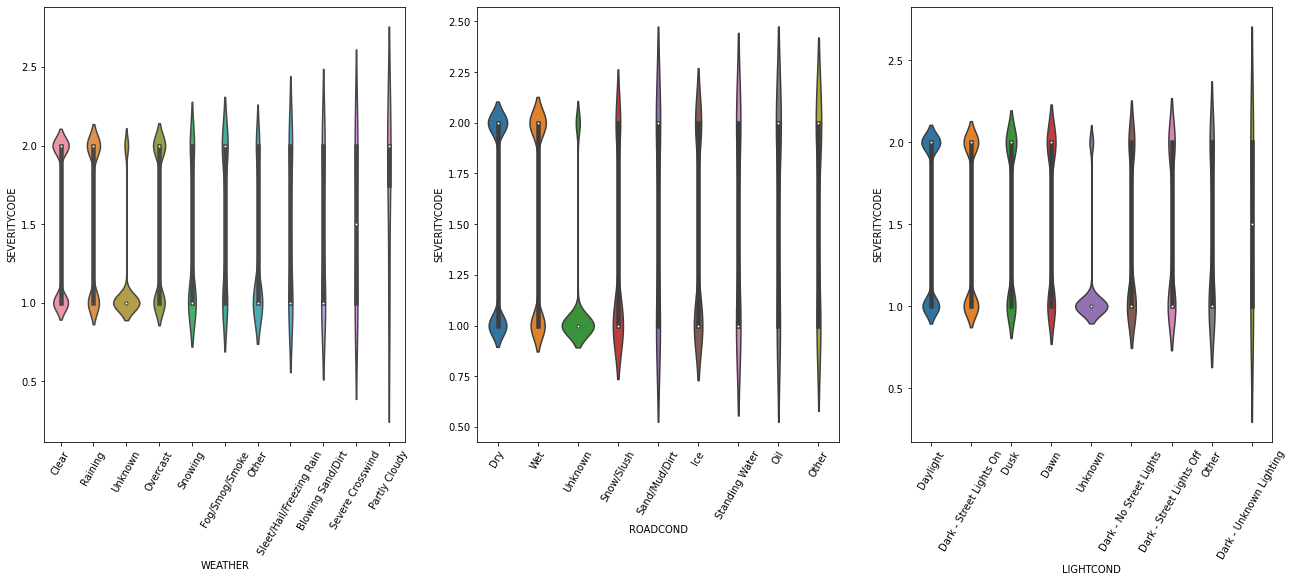

In [27]:
fig = plt.figure(figsize=(22, 8))

fig.add_subplot(1, 3, 1)
sns.violinplot(data=df_collisions, x='WEATHER', y='SEVERITYCODE')
plt.xticks(rotation=60)

fig.add_subplot(1, 3, 2)
sns.violinplot(data=df_collisions, x='ROADCOND', y='SEVERITYCODE')
plt.xticks(rotation=60)

fig.add_subplot(1, 3, 3)
sns.violinplot(data=df_collisions, x='LIGHTCOND', y='SEVERITYCODE')
plt.xticks(rotation=60)

These values have some numerical sequencing. Let's label encode this 3 columns:

In [28]:
le_weather = LabelEncoder()
df_collisions['WEATHER'] = le_weather.fit_transform(df_collisions['WEATHER'])

le_roadcond = LabelEncoder()
df_collisions['ROADCOND'] = le_roadcond.fit_transform(df_collisions['ROADCOND'])

le_lightcond = LabelEncoder()
df_collisions['LIGHTCOND'] = le_lightcond.fit_transform(df_collisions['LIGHTCOND'])

In [29]:
print(df_collisions.shape)

(116376, 21)


### Scatterplot

<AxesSubplot:xlabel='SEVERITYCODE', ylabel='VEHCOUNT'>

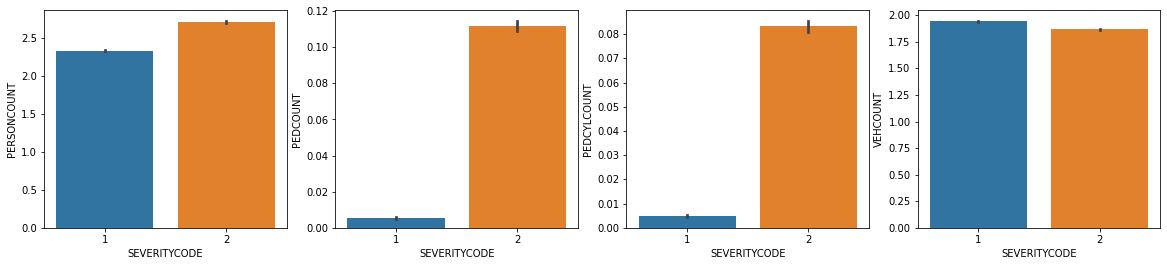

In [30]:
fig = plt.figure(figsize=(20, 4))

fig.add_subplot(1, 4, 1)
sns.barplot(data=df_collisions, x='SEVERITYCODE', y='PERSONCOUNT')

fig.add_subplot(1, 4, 2)
sns.barplot(data=df_collisions, x='SEVERITYCODE', y='PEDCOUNT')

fig.add_subplot(1, 4, 3)
sns.barplot(data=df_collisions, x='SEVERITYCODE', y='PEDCYLCOUNT')

fig.add_subplot(1, 4, 4)
sns.barplot(data=df_collisions, x='SEVERITYCODE', y='VEHCOUNT')

### Boxplot

<AxesSubplot:xlabel='SEVERITYCODE', ylabel='VEHCOUNT'>

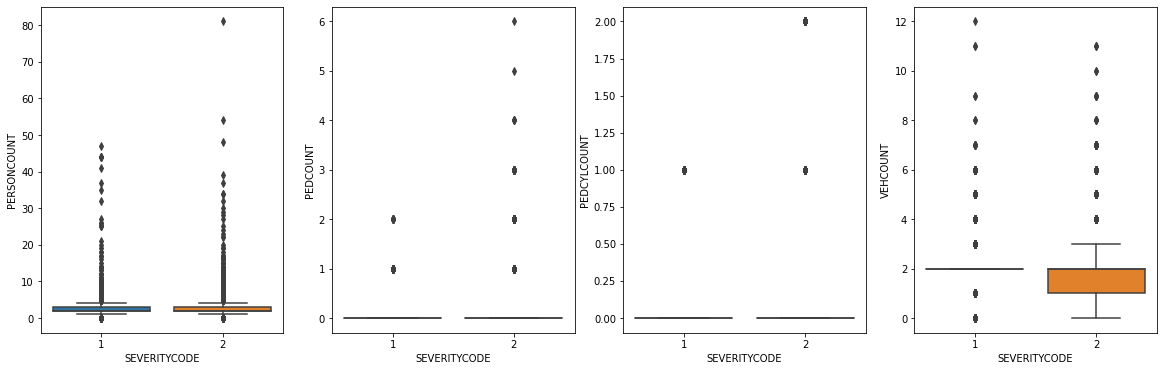

In [31]:
fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1, 4, 1)
sns.boxplot(data=df_collisions, x='SEVERITYCODE', y='PERSONCOUNT')

fig.add_subplot(1, 4, 2)
sns.boxplot(data=df_collisions, x='SEVERITYCODE', y='PEDCOUNT')

fig.add_subplot(1, 4, 3)
sns.boxplot(data=df_collisions, x='SEVERITYCODE', y='PEDCYLCOUNT')

fig.add_subplot(1, 4, 4)
sns.boxplot(data=df_collisions, x='SEVERITYCODE', y='VEHCOUNT')

### Violinplot

<AxesSubplot:xlabel='SEVERITYCODE', ylabel='VEHCOUNT'>

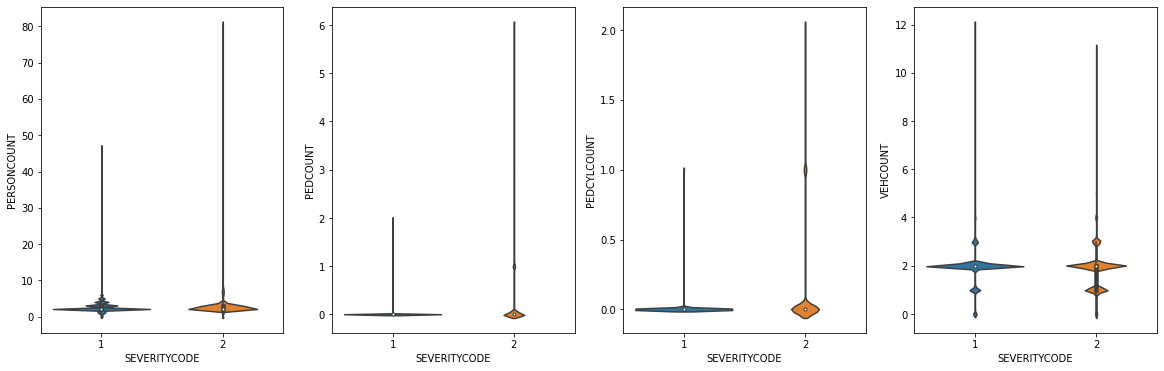

In [32]:
fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1, 4, 1)
sns.violinplot(data=df_collisions, x='SEVERITYCODE', y='PERSONCOUNT')

fig.add_subplot(1, 4, 2)
sns.violinplot(data=df_collisions, x='SEVERITYCODE', y='PEDCOUNT')

fig.add_subplot(1, 4, 3)
sns.violinplot(data=df_collisions, x='SEVERITYCODE', y='PEDCYLCOUNT')

fig.add_subplot(1, 4, 4)
sns.violinplot(data=df_collisions, x='SEVERITYCODE', y='VEHCOUNT')

## Modeling <a name="modeling"></a>

Apesar da variável dependente ter um tipo INT64, estamos lidando com um problema de classificação, não de regressão, então usaremos alguns algoritmos visualizados no curso, e alguns estudados em outras plataformas, para tentar prever a gravidade de acidentes futuros.

O que precisamos fazer primeiro é escolher algumas colunas que tem mais impacto nos resultados finais, assim a gente evita que o algoritmo perca acuracia por estar lidando com variáveis inuteis

Pensei em utilizar K-nearest neighbors, Support Vector Machine, RandomForest e Logistic Regression para analisar os dados e ver qual deles se saí melhor no final.

### Feature selection

Now we have 21 columns. We can select a small set of columns to have a better accuracy using <b>SelectKBest</b>

In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

In [34]:
min_max_scaler = MinMaxScaler()
df_norm = pd.DataFrame(min_max_scaler.fit_transform(df_collisions.drop('SEVERITYCODE', axis=1)))

feature_selection = SelectKBest(score_func=chi2, k=15)

df_norm = feature_selection.fit_transform(df_norm, df_collisions['SEVERITYCODE'])

df_norm = pd.DataFrame(df_norm)

df_norm["SEVERITYCODE"] = df_collisions['SEVERITYCODE'].values

We can use pairplot to check binomial relation between the variables in our dataset. With this technique, we can choose the best ML algotithms to use.

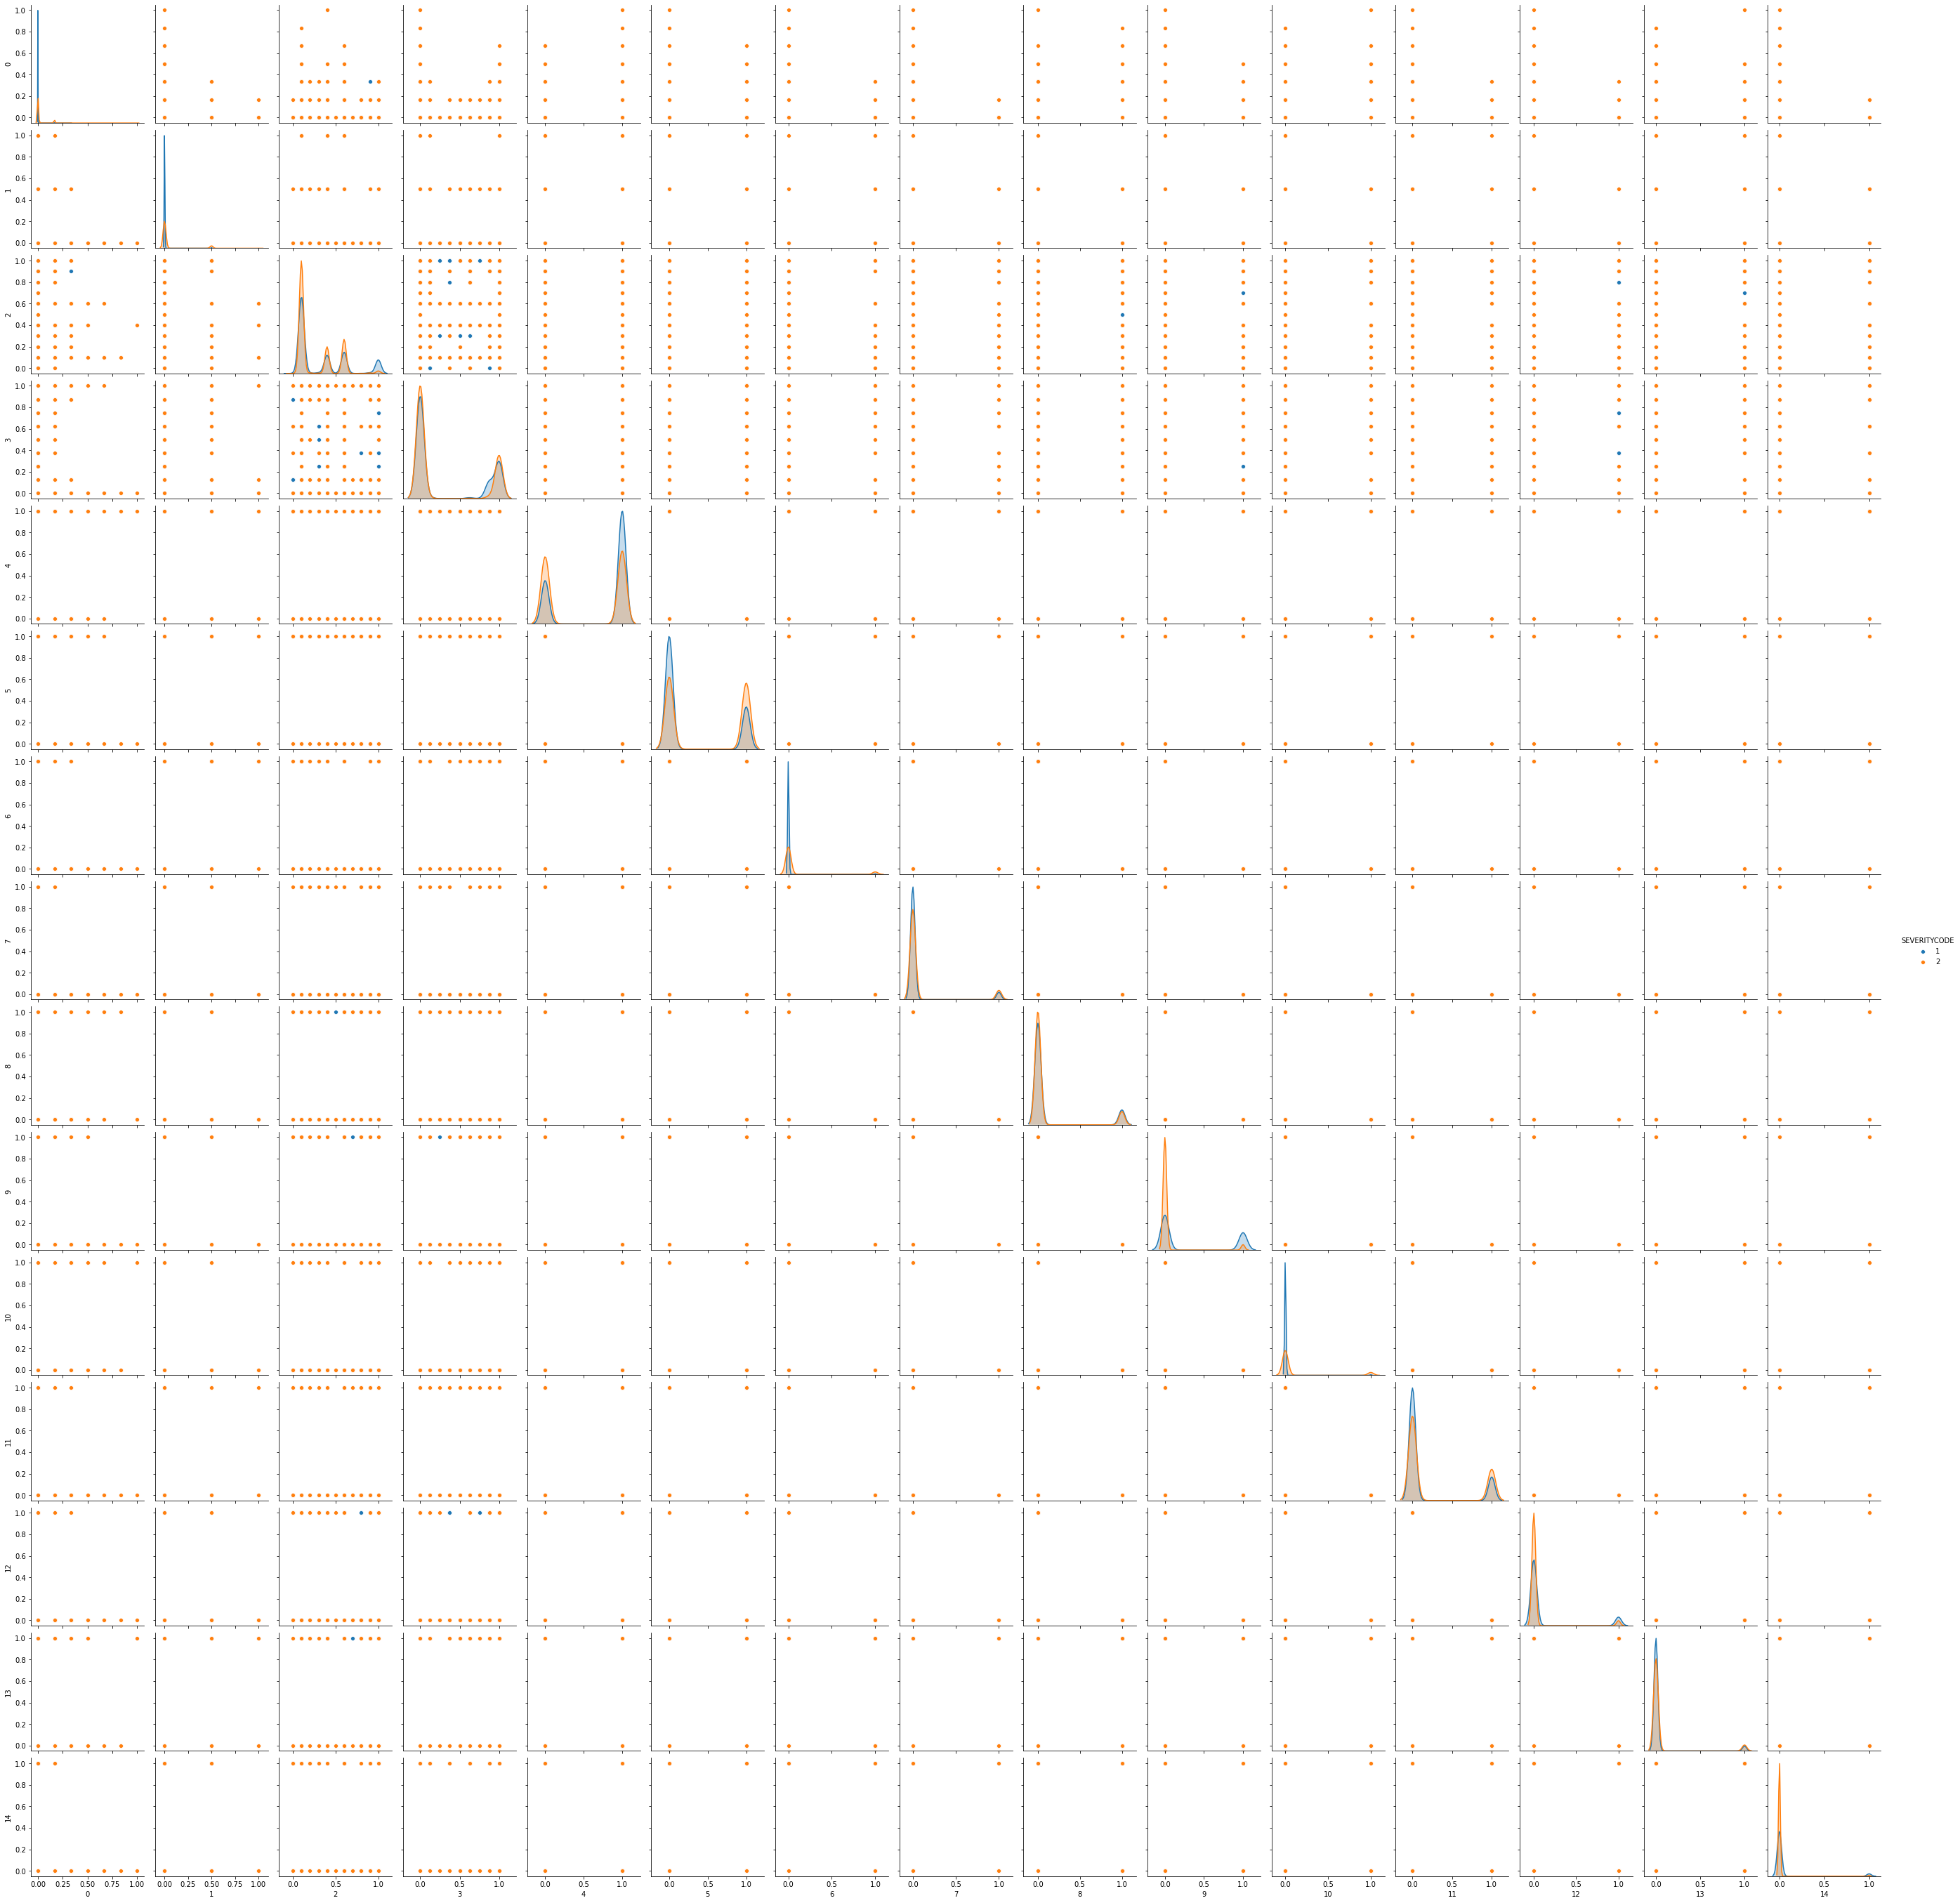

In [35]:
sns.pairplot(df_norm, hue='SEVERITYCODE')

Parece que não conseguimos desenhar uma linha para separar os dados, logo podemos ignorar o uso da Regressão Logística, já que ela consiste em desenhar uma linha reta para separar nossos dados.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

Agora vamos separar parte dos dados para treinar nosso modelo e parte para testar a acuracia dos nossos algoritmos.

In [37]:
X = df_norm.drop('SEVERITYCODE', axis=1)
y = df_norm[['SEVERITYCODE']]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(x_train.shape, y_train.shape)

(93100, 15) (93100, 1)


In [38]:
# KNN
model_knn = KNeighborsClassifier()
model_knn.fit(x_train, y_train)

y_pred_knn = model_knn.predict(x_test)

In [39]:
# RandomForest
model_forest = RandomForestClassifier(n_estimators=100, criterion='entropy')
model_forest.fit(x_train, y_train)

y_pred_forest = model_forest.predict(x_test)

In [40]:
# LinearSVM
model_linearsvm = LinearSVC()
model_linearsvm.fit(x_train, y_train)

y_pred_linearsvm = model_linearsvm.predict(x_test)

## Evaluation <a name="evaluation"></a>

Agora, iremos verificar os resultados dos nossos algoritmos. Usaremos a função <b>classification_report</b> para avaliar a precision, recall e f1-score dos nossos algoritmos de classificação.

In [41]:
from sklearn.metrics import accuracy_score

In [42]:
print("KNN accuracy:" + str(accuracy_score(y_test, y_pred_knn)))
print("Random Forest accuracy:" + str(accuracy_score(y_test, y_pred_forest)))
print("LinearSVM accuracy:" + str(accuracy_score(y_test, y_pred_linearsvm)))

KNN accuracy:0.6588331328406942
Random Forest accuracy:0.6881766626568139
LinearSVM accuracy:0.6871025949475855


In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
knn_parameters = [
    {'n_neighbors': range(1, 11), 'weights': ['uniform', 'distance'], 'n_jobs': [-1]}
]

grid_search_knn = GridSearchCV(
    estimator=model_knn,
    param_grid=knn_parameters,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_knn.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_jobs': [-1], 'n_neighbors': range(1, 11),
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [45]:
randf_parameters = [
    {'criterion': ['gini', 'entropy'], 'n_jobs': [-1]}
]

grid_search_randf = GridSearchCV(
    estimator=model_forest,
    param_grid=randf_parameters,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_randf.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy'), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'], 'n_jobs': [-1]}],
             scoring='accuracy')

In [47]:
linearsvm_parameters = [
    {'C': [1, 10, 100, 1000], 'penalty': ['l1', 'l2']}
]

grid_search_linearsvm = GridSearchCV(
    estimator=model_linearsvm,
    param_grid=linearsvm_parameters,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_linearsvm.fit(x_train, y_train)

GridSearchCV(estimator=LinearSVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'penalty': ['l1', 'l2']}],
             scoring='accuracy')

In [52]:
print("KNN accuracy now: " + str(grid_search_knn.best_score_) + ' with parameters: ' + str(grid_search_knn.best_params_))
print("SVM accuracy now: " + str(grid_search_linearsvm.best_score_) + ' with parameters: ' + str(grid_search_linearsvm.best_params_))
print("RandomForest accuracy now: " + str(grid_search_randf.best_score_) + ' with parameters: ' + str(grid_search_randf.best_params_))

KNN accuracy now: 0.6587755102040816 with parameters: {'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}
SVM accuracy now: 0.6959505907626209 with parameters: {'C': 10, 'penalty': 'l2'}
RandomForest accuracy now: 0.6986680988184747 with parameters: {'criterion': 'gini', 'n_jobs': -1}


## Conclusion <a name="conclusion"></a>

70% parece ser um resultado descente para esse projeto e baseando-se no fato de que temos poucos dados para treinar nossos algoritmos. Como o dataset era desbalanceado, precisamos remover muitas linhas e assim perdemos informação. 
Algo que não fizemos foi tentar ajustar paramêtros para os algoritmos, de inicio os resultados estão crus, mas em breve vamos adicionar novos paramêtros e comparar os resultados obtidos. Haja visto que todas as amostras colhidas e escolhidas foram aleatórias, podemos obter resultados diferentes, com certa variação, até para os métodos utilizados agora. Assim, irei considerar usar os paramêtros para ver se conseguimos obter um resultado bem melhor, algo em torno de 75%+ de média-ponderada na pontuação f1.